In [1]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain.messages import SystemMessage
from langchain.messages import ToolMessage
from typing import Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain.messages import HumanMessage
import os
os.environ['ANTHROPIC_API_KEY'] = open('/Users/spangher/.anthropic-usc-key.txt').read().strip()
os.environ["OPENAI_API_KEY"] = open('/Users/spangher/.openai-reglab-project-key.txt').read().strip()
os.environ['LANGSMITH_TRACING']='true'
os.environ['LANGSMITH_ENDPOINT']='https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY']=open('/Users/spangher/.langsmith-key.txt').read().strip()
os.environ['LANGSMITH_PROJECT']="My First App"

model = init_chat_model(
    "gpt-5-mini",
    temperature=0,
)

In [2]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

In [3]:
# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Define tool node
def tool_node(state: dict):
    """Performs the tool call"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {
        "messages": result
    }

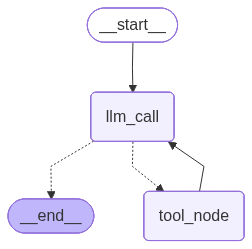

In [4]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_mV4aQA7SCrEDMQ9uYPwxpGwG)
 Call ID: call_mV4aQA7SCrEDMQ9uYPwxpGwG
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

7


In [6]:
messages

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 246, 'total_tokens': 336, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D2lDD2aUYTlKCSFzN4pLcdz5cpVIA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c016d-fc66-7c01-b026-76349d872ddf-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_mV4aQA7SCrEDMQ9uYPwxpGwG', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 246, 'output_tokens': 90, 'total_tokens': 336, 'input_token_details': {'audio': 0, 'cache